# 11-13. 프로젝트: 뉴스기사 요약해보기

들어가기 전에 

``` terminal 
pip install nltk
pip install beautifulsoup4
pip install lxml
pip install summa
```

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/ssac4/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 최대 줄 수 설정
pd.set_option('display.max_rows', 500)
# 최대 열 수 설정
pd.set_option('display.max_columns', 500)
# 표시할 가로의 길이
pd.set_option('display.width', 1000)


## Step 1. 데이터 수집하기
데이터는 아래 링크에 있는 뉴스 기사 데이터(newssummarymore.csv)를 사용합니다. 
데이터 주스 https://github.com/sunnysai12345/News_Summary
    

In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
data.sample(10)


,headlines,text
55454,India achieves its best year-end FIFA ranking ...,The Indian men's football team has ended the y...
79416,PMO wants military school model at all schools...,The Prime Minister's Office has asked the Huma...
86697,Ethiopia turns off internet nationwide to prev...,Ethiopia has turned off its internet access na...
82536,"For every 0.55ÃÂºC temp rise, US to lose 0.7%...",Researchers examining the economic consequence...
24055,US media dying to see my government make mista...,US President Donald Trump has said the America...
63672,"Earlier for fashion, now Khadi for transformat...","Prime Minister Narendra Modi on Sunday said, ""..."
41374,Don't want to call you refugees: BJP leader to...,Addressing an event organised by the Tibetan g...
31907,Hindu group moves SC against Congress' K'taka ...,Rashtriya Hindu Sena chief Pramod Muthalik has...
25525,England end India's longest ODI series winning...,England defeated India in the third ODI on Tue...
46555,"People of India are kind, genuine and open: Ca...","Canadian PM Justin Trudeau, who is on a state ..."


##  데이터 전처리하기 (추상적 요약)

aiffel 에서 배운 전처리를 참고하여 추가적인 전처리를 하겠습니다.
불용어 제거를 한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는게 좋을지 고찰해 보겠습니다.

In [5]:
print(f'{data.columns[0]:5} 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print(f'{data.columns[1]:5} 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text  열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [6]:
 data.nunique()

headlines    98280
text         98360
dtype: int64

headline은 중복되는데 text는 다른 것들이 존재하는것이 보입니다. 이것들을 확인해보겠습니다. 
headline은 요약이기 때문에 text가 달라도 headline이 동일할수 있습니다. 하지만 혹시 모를 오류가있으니 확인해보겠습니다.
일단 text가 중복인 경우는 무조건 중복 샘플이니 제외해보겠습니다. 

In [7]:
data.drop_duplicates(['text'], inplace = True)

In [8]:
data.nunique()

headlines    98262
text         98360
dtype: int64

In [9]:
data.drop_duplicates(subset = ['headlines'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98262


In [10]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [11]:
data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98262


In [12]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [13]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [14]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [15]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

headlines에 대해서는 불용어 제거를 하지 않도록 하겠습니다.

In [16]:
clean_summary = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

clean_summary[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [17]:
data['headlines'] = clean_summary
data['text'] = clean_text

혹시 전처리 이후 다시 공백이 생긴게 아닌지 확인합니다.

In [18]:
data.replace('', np.nan, inplace=True)

In [19]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [20]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))#데이터 전처리 함수

전체 샘플수 : 98262


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.10029309397326
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299444342675704


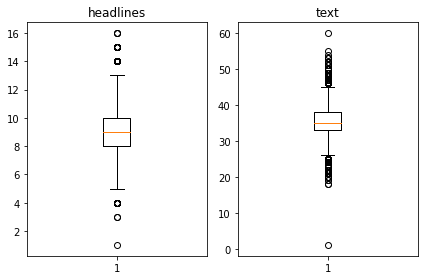

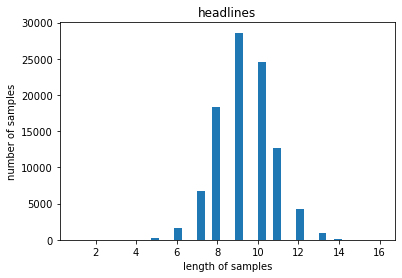

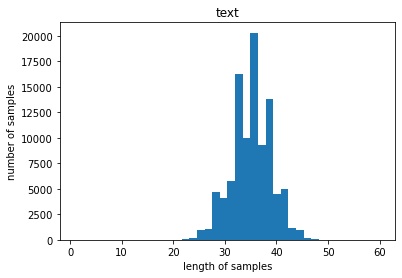

In [21]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [22]:
np.argmin(text_len)

52

무언가 text에 너무 짧은게 존재합니다. 확인해보겠습니다.

In [23]:
text_len[text_len == 1]

39

In [24]:
data.iloc[52,]

headlines    headlines
text              text
Name: 52, dtype: object

뭔가 잘못된 데이터가 입력된것을 확인할 수 있었습니다. 

In [25]:
data

,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...
...,...,...
98396,crpf jawan axed to death by maoists in chhatti...,crpf jawan tuesday axed death sharp edged weap...
98397,first song from sonakshi sinha noor titled uff...,uff yeh first song sonakshi sinha starrer upco...
98398,the matrix film to get reboot reports,according reports new version science fiction ...
98399,snoop dogg aims gun at clown dressed as trump ...,new music video shows rapper snoop dogg aiming...


In [26]:
data.iloc[1,]

headlines    delhi techie wins free food from swiggy for on...
text         kunal shah credit card bill payment platform c...
Name: 1, dtype: object

In [27]:
data.drop([52], inplace = True)

In [28]:
data.iloc[52,]

headlines    oneplus named bestselling premium smartphone b...
text         oneplus emerged india best selling premium sma...
Name: 53, dtype: object

값을 삭제한 것을 볼 수 있습니다. 

이제 패딩할 수치를 지정하겠습니다.

In [29]:
text_max_len = 40
headlines_max_len = 12

In [30]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [31]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238354993334079
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880318742939722



최소값보다 적은 samaple은 제외하고 해보겠습니다.

In [32]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 89681


## 토큰 추가

 디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈추는 거였죠.
 seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있어요. 이번 실습에서는 시작 토큰은 'sostoken', 종료 토큰은 'eostoken'이라 임의로 명명하고 앞, 뒤로 추가할거에요. 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 이름을 정했어요. 두 개의 문장 모두 Summary 열로부터 만들거에요.

In [33]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장합니다.



In [34]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

## train , test 데이터 분리


In [35]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[33602 56379 13596 ... 52282 44517 63386]


In [36]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [37]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 17936


In [38]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 71745
훈련 레이블의 개수 : 71745
테스트 데이터의 개수 : 17936
테스트 레이블의 개수 : 17936


## 단어 집합(vocaburary) 만들기 및 정수 인코딩

In [39]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [40]:
threshold = 8
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 65580
등장 빈도가 7번 이하인 희귀 단어의 수: 46023
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19557
단어 집합에서 희귀 단어의 비율: 70.17840805123512
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.051118897185989


총 단어는 65629개 그러나 등장빈도가 threshold 7회미만 즉 6회 이하 단어는 단어집합에서 70% 정도를 찿지함
하지만 실제 훈련데이터에서 등장빈도 비율은 4% 밖에 되지않음.

In [41]:
src_vocab = 19538
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 19538으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [42]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[169, 15, 122, 54, 1, 4148, 1041, 11769, 683, 7486, 36, 1944, 347, 7272, 254, 18328, 7718, 1415, 9624, 254, 17, 18328, 7718, 868, 2281, 1058, 11769, 68, 868, 2281, 1], [396, 318, 3170, 3441, 198, 282, 5, 16, 124, 45, 976, 259, 1981, 118, 239, 318, 9, 21, 93, 5, 2465, 1161, 766, 1561, 435, 5015, 1566, 4091, 3852, 198, 282, 45, 2], [47, 2163, 783, 174, 1391, 13867, 1, 4593, 10, 641, 13867, 1, 378, 28, 143, 357, 174, 185, 139, 1, 5016, 10, 7719, 405, 31, 4172, 291, 538, 405, 364, 284, 185]]


In [43]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [44]:
threshold = 8
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28844
등장 빈도가 7번 이하인 희귀 단어의 수: 20523
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8321
단어 집합에서 희귀 단어의 비율: 71.15171266121204
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.325105443351562


In [45]:
tar_vocab =  8283
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 151, 986, 819, 6844, 11, 24, 2343], [1, 439, 5528, 7, 135, 48, 146, 123, 229, 28], [1, 709, 753, 7770, 23, 21, 18, 191, 113, 139, 738, 1048], [1, 389, 809, 940, 1739, 166, 76, 281, 443, 36], [1, 425, 263, 327, 23, 10, 288, 150, 953, 550, 2437]]
target
decoder  [[151, 986, 819, 6844, 11, 24, 2343, 2], [439, 5528, 7, 135, 48, 146, 123, 229, 28, 2], [709, 753, 7770, 23, 21, 18, 191, 113, 139, 738, 1048, 2], [389, 809, 940, 1739, 166, 76, 281, 443, 36, 2], [425, 263, 327, 23, 10, 288, 150, 953, 550, 2437, 2]]


전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있어요. 이 현상은 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 4밖에 되지 않았던 요약문(Summary)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높겠죠.

요약문에서 길이가 0이 된 샘플들의 인덱스를 받아와볼게요. 여기서 주의할 점은 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제 되지 않아요. 그래서 이제 길이가 0이 된 요약문의 실제길이는 1로 나올거에요. 길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있을테니까요.

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장해볼게요. 이 샘플들은 모두 삭제할거에요.



In [46]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 71745
훈련 레이블의 개수 : 71745
테스트 데이터의 개수 : 17936
테스트 레이블의 개수 : 17936


/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## 패딩하기

In [47]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

## 어텐션 메커니즘 사용하기 (추상적 요약)

### 모델 설계 하기 

#### 인코더 

In [48]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

#### 디코더 입력

In [49]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

#### 디코더 출력

In [50]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2500864     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 어텐션 메커니즘

깃헙에서 공개되어있는 어텐션 함수를 다운로드 받아서 쓰겠습니다.

In [51]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

다운받은걸 쓰기 때문에 디코더 출력층을 살짝 변경함

In [52]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2500864     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용,          
어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동함

### 모델 훈련하기

In [56]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
281/281 [==============================] - 112s 398ms/step - loss: 5.4894 - val_loss: 5.0921
Epoch 2/50
281/281 [==============================] - 109s 388ms/step - loss: 4.9518 - val_loss: 4.7430
Epoch 3/50
281/281 [==============================] - 110s 391ms/step - loss: 4.6026 - val_loss: 4.4559
Epoch 4/50
281/281 [==============================] - 108s 383ms/step - loss: 4.3269 - val_loss: 4.2605
Epoch 5/50
281/281 [==============================] - 105s 374ms/step - loss: 4.1210 - val_loss: 4.1488
Epoch 6/50
281/281 [==============================] - 106s 377ms/step - loss: 3.9582 - val_loss: 4.0188
Epoch 7/50
281/281 [==============================] - 108s 385ms/step - loss: 3.8199 - val_loss: 3.9332
Epoch 8/50
281/281 [==============================] - 102s 362ms/step - loss: 3.6964 - val_loss: 3.8598
Epoch 9/50
281/281 [==============================] - 101s 361ms/step - loss: 3.5862 - val_loss: 3.7980
Epoch 10/50
281/281 [==============================] - 102s 361m

29 Epoch에서 early stop했습니다.

In [54]:
# from tensorflow.keras.models import load_model
# # model.save('Abs_Summ_model.h5')

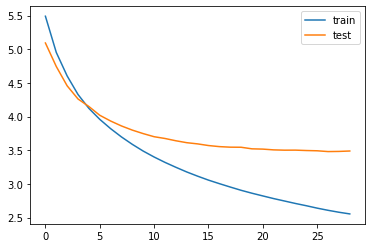

In [57]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

val_loss가 3.5부근에서 수렴하는것을 확인했습니다.

In [58]:
# model = load_model('Abs_Summ_model.h5')


### 인퍼런스 모델 구현하기

사전을 준비

In [59]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [60]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

어텐션 메커니즘 사용하는 출력층 설계

In [61]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

In [62]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 모델 테스트 하기 

주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수

In [63]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

## 실제 결과와 요약문 비교하기 (추상적 요약)

In [64]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : online food delivery startup swiggy planning add women food delivery fleet march identifying safe zones women personnel operate let complete deliveries pm startup said currently swiggy women delivering food across cities including ahmedabad kolkata mumbai pune 
실제 요약 : swiggy to hire women for food delivery by march 
예측 요약 :  swiggy launches service service in delhi


원문 : social activist patkar fasting people displaced due sardar sarovar dam ended day long fast saturday broke fast dhar jail madhya pradesh detained past three days charged calling meeting district imposition section 
실제 요약 : bachao activist ends fast after days 
예측 요약 :  anna hazare missing after years since


원문 : least people killed two separate landslides triggered heavy rains northwest china officials said wednesday government dispatched rescue workers help affected last month people killed landslides floods central province 
실제 요약 : killed in two landslides in china 
예측 요약 :  killed in iran floods in china


원

예측 요약 :  musk says he is the reason to musk tim cook


원문 : un appealed lakh crore humanitarian aid un agencies organisations said sum would used help crore people among world vulnerable billion needed address humanitarian syria yemen syria requiring billion aid alone 
실제 요약 : un appeals for record lakh crore aid in 
예측 요약 :  un to pay crore to aid for cr aid to aid


원문 : hyderabad man employed saudi arabia riyadh announced talaq wife advertisement published urdu daily march unhappy spoken married front divorced front relatives said wife 
실제 요약 : man in wife in hyd through newspaper ad 
예측 요약 :  saudi man jailed for not giving husband to wife


원문 : congress leader dk shivakumar claimed karnataka cm bs yeddyurappa resign ahead trust motion scheduled pm today said mla anand singh quit bjp join congress january vote congress floor test comes reports claimed yeddyurappa meet governor vajubhai vala saturday resign 
실제 요약 : cm yeddyurappa will resign before trust vote cong leader 
예측 요약 : 

예측 요약 :  air india express express to be launched in


원문 : former australia captain michael clarke said team india captain virat kohli greatest batsman ever played odi cricket doubts seeing achieved india year old world cup winning captain added kohli aggression one question commitment much achieved clarke said 
실제 요약 : kohli is the greatest batsman to have played odi cricket clarke 
예측 요약 :  kohli has been good for the world cup clarke


원문 : bjp wednesday called two day protests kerala two women age entered sabarimala temple kerala bjp president ps sreedharan pillai called entry conspiracy rulers destroy hindu temples however asked devotees get carried away register protest democratic means 
실제 요약 : bjp calls for protests after women below enter sabarimala 
예측 요약 :  women protest for sabarimala temple in sabarimala bjp


원문 : australian detained us visa minutes freed two weeks imprisonment five year visa requiring leave every six months arrested american officials tried entering can

예측이 놀랄만큼 잘된것도있고 좋지못한 것도 있습니다.

## Summa을 이용해서 추출적 요약해보기

In [65]:
from summa.summarizer import summarize

Summa의 summarize()의 인자로 사용되는 값들

text (str) : 요약할 테스트.                  
ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값                    
words (int or None, optional) – 출력에 포함할 단어 수.                                              
만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.                     
split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환                  

**단 summa의 summarize가 사용하는 text Rank 기법은 문장 안의 단어를 사용하여 문장의 ranking을 계산하는 방법입니다.      
즉 우리의 글이 여러 문장으로 나뉘어져 있어야 추출적 요약이 가능합니다.**

그렇기 때문에 저는 이미 전처리된 text의 단어마다 7번째마다 .을 찍는것으로 문장화 시켰습니다.

이는 임의적인 방법이기때문에 문법이나 추출에 있어서 성능을 매우 떨어트릴것같습니다.

## 추상적 요약과 추출적 요약의 비교
두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시해보겠습니다.

In [157]:
for i in range(50,100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("\n")
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("\n")
    print("추상적 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    dot_index = 0
    en_txt = []
    for j in seq2text(encoder_input_test[i]).split() :
        en_txt.append(j)
        dot_index += 1
        if dot_index % 5 == 4:
            en_txt.append(".")
    print("\n")
    print("추출적 요약:", summarize(' '.join(en_txt), ratio = 0.3 , words = 10))
    print("\n")

원문 : online food delivery startup swiggy planning add women food delivery fleet march identifying safe zones women personnel operate let complete deliveries pm startup said currently swiggy women delivering food across cities including ahmedabad kolkata mumbai pune 


실제 요약 : swiggy to hire women for food delivery by march 


추상적 요약 :  swiggy launches service service in delhi


추출적 요약: online food delivery startup .
swiggy planning add women food .


원문 : social activist patkar fasting people displaced due sardar sarovar dam ended day long fast saturday broke fast dhar jail madhya pradesh detained past three days charged calling meeting district imposition section 


실제 요약 : bachao activist ends fast after days 


추상적 요약 :  anna hazare missing after years since


추출적 요약: social activist patkar fasting .
dam ended day long fast .


원문 : least people killed two separate landslides triggered heavy rains northwest china officials said wednesday government dispatched rescue workers help aff

추상적 요약 :  delhi man arrested for drunken driving while driving


추출적 요약: two delhi teenagers arrested .
car returned village dwarka arrested .


원문 : swachh bharat abhiyan mascot bai passed away aged chhattisgarh raipur due prolonged illness state government selected mascot sold goats build toilets house bai efforts make village open defecation free pm narendra modi urged media spread story 


실제 요약 : yr old swachh bharat mascot passes away 


추상적 요약 :  raj organises puja to be dies after independence day


추출적 요약: swachh bharat abhiyan mascot .
government selected mascot sold goats .


원문 : music festival organisers uk planning allow people test illegal drugs attempt reduce drug related deaths people able take drugs testing tent told drugs contents destroyed scheme tested last year people tested illegal drugs england 


실제 요약 : music may allow people to test illegal drugs 


추상적 요약 :  uk to ban drug drug drug offenders in


추출적 요약: testing tent told drugs contents .
people tested ille

추상적 요약 :  year old becomes st woman to give wife to marry wife


추출적 요약: year old clay tablet .
years marriage slave would freed .


원문 : australian cricketer david warner issued public apology involvement ball tampering south africa saying game love warner instructed team youngest member cameron bancroft carry plan banned international domestic cricket year leading australian team ever 


실제 요약 : it is on game warner apologises for ball tampering 


추상적 요약 :  warner warner to be tampering in australia


추출적 요약: australian cricketer david warner .
leading australian team ever


원문 : pope francis said pray sometimes fall asleep adding christians feel like children lying fathers arms claiming saints also known sleep praying pope said th century french nun saint pope sleeps pm every night wakes 


실제 요약 : pope francis says he sometimes falls asleep while 


추상적 요약 :  pope francis is the children pope francis


추출적 요약: pope francis said pray .
sleep praying pope said th .


원문 : politician

* 추상적 요약:
장점: 

1. 요약과 비슷한 문장 구조. 아무래도 문장구조를 요약을 통해서 학습시켰기때문에 문장구조가 유사합니다.       
2. 단순한 단어 추출이 아니라 없던 단어를 통해 요약을 해냄, 그래서 좀 어색하긴해도 어느정도 실제 요약과 비슷한 단어를 만들어냄                          
     
단점: 

1. 아직 학습 수준이 부족하다.                    
2. 모델 적합에 너무 오랜 시간이 걸린다.                   

* 추출적 요약:  

단점: 
1. 또한 분량이 짧다 보니 거의 그대로 첫번째 문장, 두번째 문장의 첫부분으로 따오는 것처럼 보입니다.                 
2. 추상적 요약은 문장구조가 요약스럽게 나오는데 그러지 못합니다. 문장 구조를 원본 text 그대로 따라가는 것 처럼 보입니다.             
3. 제가 임의로 숫자대로 문장단위를 끊어내다 보니 제대로 요약이 되지않은 것처럼 보이기도합니다.                 
     
장점: 

1. 반대로 짧은 원문에서 그대로 용어를 따오다보니 요약의단어는 괜찮게 나오는 것처럼 보이기도 합니다.            
2. 연산이 빠르다. 복잡한 모델을 사용한 추상적 요약에 비해서 훨씬 빠르게 계산됨           



In [158]:
# ttttttt = []

# for i in range(50,51):
#     a = 0
#     for j in seq2text(encoder_input_test[i]).split() :
#         ttttttt.append(j)
#         a += 1
#         if a % 8 == 4 :
#             ttttttt.append(".")

# print(' '.join(ttttttt))

# 소고 

추출적 요약의 summarize가 잘 되지않아서 고생했습니다.     
알고보니 summarize는 문장끼리의 단어를 통해서 연결을 하는것이기 때문에 문장부호가 존재해야하는 것이었습니다. 

추상적 요약이 신기할 정도로 잘 되는것도있고 잘 되지않는 것도 있었습니다.                  
뭔가 더 구체적인 알고리즘에 대해서 알고 싶음.          
모델 학습에 상당히 시간이 걸리는데 
model.save('Abs_Summ_model.h5')
model = load_model('Abs_Summ_model.h5')
로 저장하고 불러오기가 안되서 고생했습니다.

뭔가 이번 작업은 모델 설계를 건들이기가 힘들어서 모법답안 말고 다른 조원들이 어떻게 했나 보고싶은데
공유가 잘안되서 슬픕니다.


아래는 하면서 제가 했던 고민들입니다.

## 최대한 데이터를 살리는 방법 고민
그것도 노가다를 하지 않고는..?

In [81]:
data1 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [85]:
data1[data1.headlines.duplicated(keep = False )].sort_values(by = 'headlines').head(16)


,headlines,text
64843,'Merchant of death' title inspired founding of...,After confusing his brother's death with that ...
15260,'Merchant of death' title inspired founding of...,A French newspaper in 1888 confused the death ...
67136,16-yr-old Afridi hit then-fastest ODI ton with...,Former Pakistani all-rounder Shahid Afridi sma...
45643,16-yr-old Afridi hit then-fastest ODI ton with...,"Former Pakistani all-rounder Shahid Afridi, wh..."
27674,1st Wimbledon was organised to fund repair of ...,"The first-ever Wimbledon competition, held in ..."
82399,1st Wimbledon was organised to fund repair of ...,"The first ever Wimbledon competition, held in ..."
72502,1st bowler hit for 6 sixes in 1 over was pacer...,West Indies' cricketing legend Gary Sobers bec...
19411,1st bowler hit for 6 sixes in 1 over was pacer...,Windies' cricketing legend Gary Sobers became ...
78244,1st player to hit 6 sixes in 1 over was born w...,"Former Windies' cricketer Garry Sobers, the fi..."
23938,1st player to hit 6 sixes in 1 over was born w...,"Former Windies' cricketer Garry Sobers, the fi..."


In [87]:
data1.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 89681


In [89]:
print(data1.iloc[34626])
print(data1.iloc[19982])

headlines          500-kg World War II bomb defused in Germany
text         German police on Friday defused a 500-kilogram...
Name: 34627, dtype: object
headlines          500-kg World War II bomb defused in Germany
text         German authorities on Sunday defused a 500-kil...
Name: 19982, dtype: object


In [67]:
data.iloc[34626].text

'German police on Friday defused a 500-kilogram World War II bomb in central Berlin, after evacuating around 10,000 people within an 800-metre radius of the bomb. The bomb was found during construction work earlier this week. More than 2,000 tonnes of live bombs and munitions are found in Germany every year.'

In [68]:
data.iloc[19982].text

'German authorities on Sunday defused a 500-kilogram World War II bomb in the city of Ludwigshafen after evacuating 18,500 people. The bomb is believed to have been dropped by US forces during World War II. More than 2,000 tonnes of live bombs and munitions are found in Germany every year.'

전처리하다 느낀것인데 

1. 위의 예시(500-kg World War II bomb)처럼 headline은 같은데 text는 (유사하지만) 다른 사건을 다룬  경우
2. 바로 밑 코드의 예시(Indian Oil Corporation)처럼 headline이 같고 text도 오타,오류로 발생한 중복 sample

이렇게 다른 케이스가 존재하고 첫번째 케이스는 단순히 삭제하기보다 살리는게 바람직한 방향인거같습니다.

그런데 문제는 이걸 일일히 노가다로 찾아봐야 하는건데
혹시 더 빠르게 해결할수있는 방법이 어떤게 있을지를 더 고민을 해봐야할 거같습니다.

제가 혼자 생각해본 방법은 

첫번째로 먼저 소문자화 시키고, /n같이 오타로 들어간 것을 제외하고 중복 데이터를 찾으면
약간은 도움이 될것같습니다. 하지만 중복 데이터  제거후 데이터 전처리를 하는것이 아니라 
반대로 데이터 전처리부터하고 중복 데이터를 정리하는 것이라 시간이 오래 걸릴 것 같습니다. 

다른 aiffel_ssac 분들은 이런 의견을 내주셨습니다.

문장마다 중복단어의 비율을 세보는건 어떨까요!
group_by의 활용

확실히 중복단어의 비율을 세는것은 좋은 방식일거같습니다. 
위의 독일폭탄도 대부분 유사하지만 Berlin이랑 Ludwigshafen, friday, sunday 정도가 다른것을 확인할 수있는데
이런 차이들을 비교해보는게 좋은 방식인거같습니다. 단어 단위로 모두 나눈 후에 얼마나 차이가 나는지 비교하는 것입니다.

In [70]:
print(data.iloc[24])
print(data.iloc[3293])

headlines    Indian Oil looking for annual deal to buy crud...
text         Indian Oil Corporation on Wednesday said it's ...
Name: 24, dtype: object
headlines    Indian Oil looking for annual deal to buy crud...
text         Indian Oil Corporation on Wednesday said it's ...
Name: 3293, dtype: object


In [71]:
data.iloc[24].text

"Indian Oil Corporation on Wednesday said it's looking for an annual deal to buy US crude as it seeks to broaden oil purchasing options. This comes amid uncertainties over Iran imports. The US had in November granted a six-month waiver to India from sanctions against Iran and restricted the country's monthly intake of Iranian oil to 3,00,000 barrels per day.\n\n"

In [72]:
data.iloc[3293].text

"Indian Oil Corporation on Wednesday said it's looking for an annual deal to buy US crude as it seeks to broaden oil purchasing options. This comes amid uncertainties over Iran imports. The US had in November granted a six-month waiver to India from sanctions against Iran and restricted the country's monthly intake of Iranian oil to 3,00,000 barrels per day.nn"

### 짧은 데이터 삭제와 보존 차이

사실저는 처음 진행할때는 text와 headlines에서 너무 짧은것들은 제외하고 모델을 학습시켜도 보았습니다.       
그렇게 하자 val_loss가 3.7145였는데 삭제하지않고 진행하니 val_loss: 3.4880의 결과가 나왔습니다.            
아무래도 짧은 내용에 대해서는 정확도를 더 높게 얻을 수 있기 때문인것같습니다.